In [1]:
import pandas as pd
import numpy as np
import math
import json


from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler
import seaborn as sns #For Data visualization
import matplotlib.pyplot as plt #Data plotting and visualization
sns.set_palette(sns.color_palette('Set2'))
import plotly.express as px
%matplotlib inline


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.cluster import KMeans

In [4]:
#Import functions
from clean_data import clean_portfolio, clean_profile, clean_transcript


portfolio_df = clean_portfolio(portfolio)

profile_da, profile_m = clean_profile(profile)

offers,transactions = clean_transcript(transcript)


In [5]:
portfolio_df

,offer_id,offer_name,offer_type,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,offer_1,bogo,10,7,10,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_2,bogo,10,5,10,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,offer_3,informational,0,4,0,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_4,bogo,5,7,5,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_5,discount,20,10,5,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer_6,discount,7,7,3,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,offer_7,discount,10,10,2,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,offer_8,informational,0,3,0,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,offer_9,bogo,5,5,5,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,offer_10,discount,10,7,2,1,1,0,1


In [6]:
offers_portfolio = pd.merge(offers, portfolio_df, left_on='offer_id', right_on='offer_id', how='inner')

In [7]:
offers_portfolio

,customer_id,event,time_in_days,offer_id,completed,received,viewed,offer_name,offer_type,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,offer_4,bogo,5,7,5,1,1,0,1
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,offer_4,bogo,5,7,5,1,1,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,offer_4,bogo,5,7,5,1,1,0,1
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,offer_4,bogo,5,7,5,1,1,0,1
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,offer_4,bogo,5,7,5,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,642b6f1bf61040efb73e1859cf00e79e,offer viewed,29,5a8bc65990b245e5a138643cd4eb9837,0,0,1,offer_8,informational,0,3,0,1,1,1,0
167577,5a3f7fcb450a4cb693ab5267b4d49b40,offer viewed,29,5a8bc65990b245e5a138643cd4eb9837,0,0,1,offer_8,informational,0,3,0,1,1,1,0
167578,ec1761735b034ae8874bc979f0cd5862,offer viewed,29,5a8bc65990b245e5a138643cd4eb9837,0,0,1,offer_8,informational,0,3,0,1,1,1,0
167579,d56386cf344c4829bbf420d1895dca37,offer viewed,29,5a8bc65990b245e5a138643cd4eb9837,0,0,1,offer_8,informational,0,3,0,1,1,1,0


In [8]:
def offer_success(column):

    offer_name = offers_portfolio[column].unique()

    all_res = []
    for offer in offer_name:

        success = offers_portfolio[offers_portfolio[column] == offer].groupby(['customer_id']).agg({'received': 'sum' ,
                                                                                                          'viewed':'sum' ,
                                                                                                          'completed': 'sum'})
        offer_count= success.add_suffix('_count')
        col_name = list(offer_count.columns)
        offer_count['view_rate'] = offer_count[col_name[1]]/offer_count[col_name[0]]
        offer_count['completed_rate'] = offer_count[col_name[2]]/offer_count[col_name[1]]
        offer_count[offer_count['completed_rate']> 1] = 1
        offer_count = offer_count.add_prefix(column+'_'+str(offer)+'_')
        #offer_count.reset_index(inplace=True)

        all_res.append(offer_count)
    
    return all_res

    
    
 

In [9]:
def offer_success_2(offers_portfolio):
    
    all_res = []
    
    columns = ['mobile','social','web']
    for column in columns:
        success = offers_portfolio[(offers_portfolio[column] == 1) & (offers_portfolio['offer_type'] != "informational")].groupby(['customer_id']).agg({'received': 'sum' ,'viewed':'sum' ,'completed': 'sum'})
        
        offer_count= success.add_suffix('_count')
        col_name = list(offer_count.columns)
        offer_count['view_rate'] = offer_count[col_name[1]]/offer_count[col_name[0]]
        offer_count['completed_rate'] = offer_count[col_name[2]]/offer_count[col_name[1]]
        offer_count[offer_count['completed_rate']> 1] = 1
        offer_count = offer_count.add_prefix(column+'_')
        #offer_count.reset_index(inplace=True)
        
        all_res.append(offer_count)
        
    return all_res

In [10]:
offer_duration    = offer_success(column = 'offer_duration')

offer_duration_7  = offer_duration[0]#7
offer_duration_10 = offer_duration[1]#10
offer_duration_5  = offer_duration[2]#5
#offer_duration_4  = offer_duration[3]#4
#offer_duration_3  = offer_duration[4]#3


offer_difficulty    = offer_success(column = 'offer_difficulty')

offer_difficulty_5  = offer_difficulty[0]#5
offer_difficulty_20 = offer_difficulty[1]#20
offer_difficulty_10 = offer_difficulty[2]#10
offer_difficulty_7  = offer_difficulty[3]#7
#offer_difficulty_0  = offer_difficulty[4]#0


offer_reward    = offer_success(column = 'offer_reward')

offer_reward_5  =offer_reward[0]#5
offer_reward_2  =offer_reward[1]#2
offer_reward_10 =offer_reward[2]#10
offer_reward_3  =offer_reward[3]#3
#offer_reward_0  =offer_reward[4]#0


offer_type               = offer_success(column = 'offer_type')

offer_type_bogo          = offer_type[0]#Bogo
offer_type_discount      = offer_type[1]#Discount
offer_type_informational = offer_type[2]#informational



offer_name      = offer_success(column = 'offer_name')

offer_name_01   = offer_name[8]#Offer_1
offer_name_02   = offer_name[4]#Offer_2
offer_name_03   = offer_name[7]#Offer_3
offer_name_04   = offer_name[0]#Offer_4
offer_name_05   = offer_name[1]#Offer_5
offer_name_06   = offer_name[6]#Offer_6
offer_name_07   = offer_name[3]#Offer_7
offer_name_08   = offer_name[9]#Offer_8
offer_name_09   = offer_name[5]#Offer_9
offer_name_10   = offer_name[2]#Offer_10

offer_channel = offer_success_2(offers_portfolio)

offer_channel_mobie = offer_channel[0]#mobile
offer_channel_social = offer_channel[1]#social
offer_channel_web = offer_channel[2]#web

In [11]:
offer_type_join = offer_type_bogo.join(offer_type_discount).join(offer_type_informational)

offer_name_join = offer_name_01.join(offer_name_02).join(offer_name_03).join(offer_name_04).join(offer_name_05).join(offer_name_06).join(offer_name_07).join(offer_name_08).join(offer_name_09).join(offer_name_10)

offer_difficulty_join = offer_difficulty_5.join(offer_difficulty_20).join(offer_difficulty_10).join(offer_difficulty_7)

offer_duration_join = offer_duration_7.join(offer_duration_10).join(offer_duration_5)

offer_reward_join = offer_reward_5.join(offer_reward_2).join(offer_reward_10).join(offer_reward_3)


cust_offer = offer_type_join.join(offer_name_join).join(offer_difficulty_join).join(offer_duration_join).join(offer_reward_join)
cust_offer


,offer_type_bogo_received_count,offer_type_bogo_viewed_count,offer_type_bogo_completed_count,offer_type_bogo_view_rate,offer_type_bogo_completed_rate,offer_type_discount_received_count,offer_type_discount_viewed_count,offer_type_discount_completed_count,offer_type_discount_view_rate,offer_type_discount_completed_rate,...,offer_reward_10_received_count,offer_reward_10_viewed_count,offer_reward_10_completed_count,offer_reward_10_view_rate,offer_reward_10_completed_rate,offer_reward_3_received_count,offer_reward_3_viewed_count,offer_reward_3_completed_count,offer_reward_3_view_rate,offer_reward_3_completed_rate
customer_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,1,1,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00116118485d4dfda04fdbaba9a87b5c,2,2,0,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,1,1,1,1.000000,1.0,2.0,2.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
0020c2b971eb4e9188eac86d93036a77,2,1,1,0.500000,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,2,2,2,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,1,1,1,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff7576017104bcc8677a8d63322b5e1,3,2,1,0.666667,0.5,2.0,2.0,2.0,1.0,1.0,...,2.0,2.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
fff8957ea8b240a6b5e634b6ee8eafcf,1,1,0,1.000000,0.0,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# read in the json files
rfm_df = pd.read_excel('rfm.xlsx')

In [13]:
rfm_df = rfm_df.iloc[0:,1:]

In [31]:
profile_offer = pd.merge(profile_m, cust_offer, on= 'customer_id')


In [32]:
profile_offer = pd.merge(profile_offer , rfm_df , on= 'customer_id')
profile_offer.drop(columns = ['rfm_segment'])

,customer_id,F,M,O,GenZ(18–25),Millennias(26-43),GenXers(44-56),Boomers(57-75),Matures(76+),"$50,000 - $74,999",...,offer_reward_3_completed_count,offer_reward_3_view_rate,offer_reward_3_completed_rate,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_cluster
0,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,7,3,77.01,1,1,3,3
1,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,7,7,159.27,1,2,4,0
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,0,1,0,1,...,NaN,NaN,NaN,8,3,57.73,1,1,2,3
3,389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,0,1,0,1,...,NaN,NaN,NaN,4,3,36.43,2,1,2,3
4,aa4862eba776480b8bb9c68455b8c2e1,1,0,0,0,0,0,1,0,1,...,NaN,NaN,NaN,3,6,85.55,2,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12790,400d0536e8794cbb855b0d882d67cbda,1,0,0,1,0,0,0,0,1,...,0.0,1.0,0.0,1,6,17.87,4,2,1,1
12791,6d5f3a774f3d4714ab0c092238f3a1d7,1,0,0,0,0,1,0,0,1,...,NaN,NaN,NaN,1,7,20.03,4,2,1,1
12792,2cb4f97358b841b9a9773a7aa05a9d77,0,1,0,0,0,0,1,0,1,...,NaN,NaN,NaN,2,7,25.97,3,2,2,1
12793,9dc1421481194dcd9400aec7c9ae6366,1,0,0,0,0,0,0,1,1,...,NaN,NaN,NaN,1,14,189.67,4,4,4,2


In [35]:
    df  = profile_offer[['customer_id','F','M','O', 'rfm_cluster']].copy()
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id', 'rfm_cluster'],ignore_index = True)
    df = df.groupby(['rfm_cluster', 'variable']).mean().reset_index()
    df = df[df['variable']!='index']
    
    df

,rfm_cluster,variable,value
0,0,F,0.479884
1,0,M,0.504893
2,0,O,0.015223
4,1,F,0.367935
5,1,M,0.619623
6,1,O,0.012442
8,2,F,0.422590
9,2,M,0.564265
10,2,O,0.013145
12,3,F,0.381701


In [39]:
def plot_data(df):
    
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id', 'rfm_cluster'],ignore_index = True)
    df = df.groupby(['rfm_cluster', 'variable']).mean().reset_index()
    df = df[df['variable']!='index']
    
    
    g = sns.FacetGrid(df, col='rfm_cluster', hue='variable', col_wrap=3, height=4, sharey=False)
    g = g.map(plt.bar, 'variable', 'value').set_titles("{col_name}")
    
    return g


In [45]:
def plot_data_test(df):
    
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id', 'rfm_cluster'],ignore_index = True)
    df = df.groupby(['rfm_cluster', 'variable']).mean().reset_index()
    df = df[df['variable']!='index']
    
    
    g = sns.FacetGrid(df, col='variable', hue='rfm_cluster', col_wrap=3, height=4, sharey=False)
    g = g.map(plt.bar, 'rfm_cluster', 'value').set_titles("{col_name}")
    
    return g

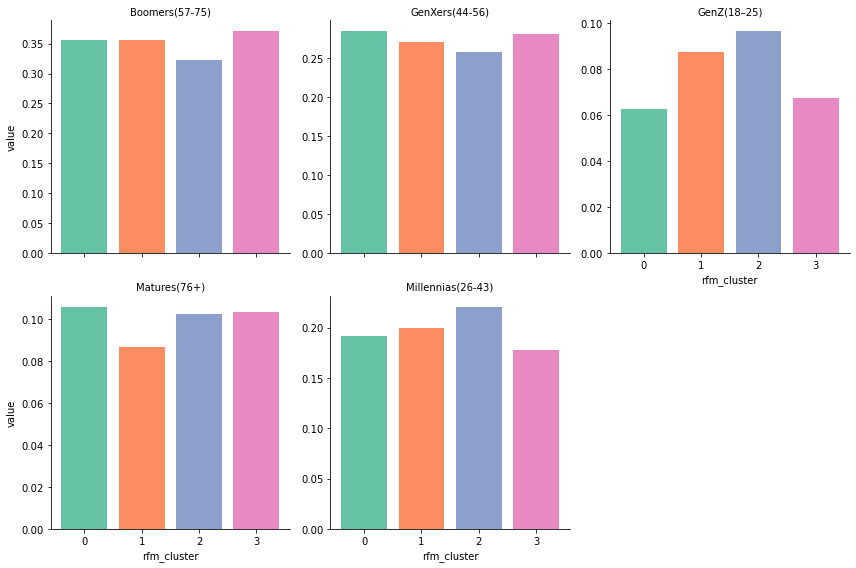

In [47]:
plot_data_test(profile_offer_age)

In [17]:
def plot_data_1(df):
    
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id', 'rfm_cluster'],ignore_index = True)
    df = df.groupby(['rfm_cluster', 'variable']).sum().reset_index()
    df = df[df['variable']!='index']
    
    
    g = sns.FacetGrid(df, col='variable', hue='rfm_cluster', col_wrap=3, height=4, sharey=False)
    g = g.map(plt.bar, 'rfm_cluster', 'value').set_titles("{col_name}")
    
    return g

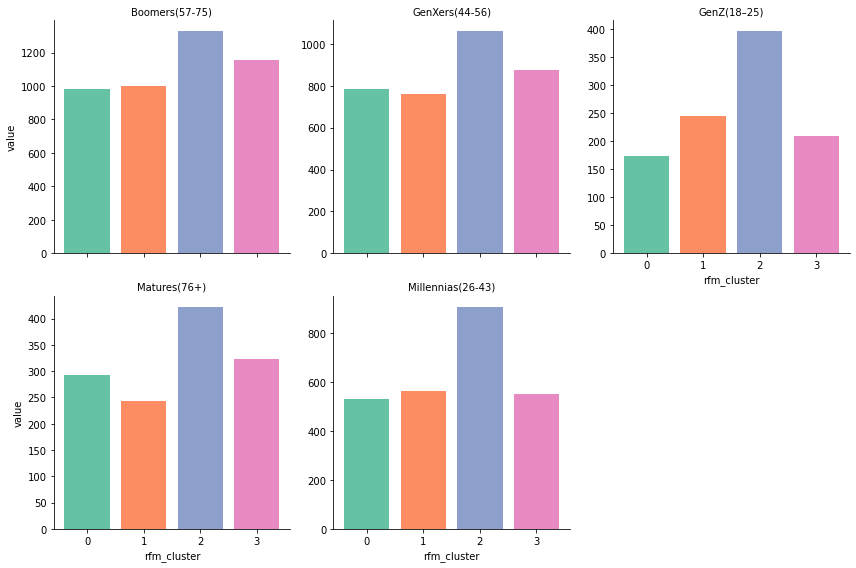

In [21]:
plot_data_1(profile_offer_age)

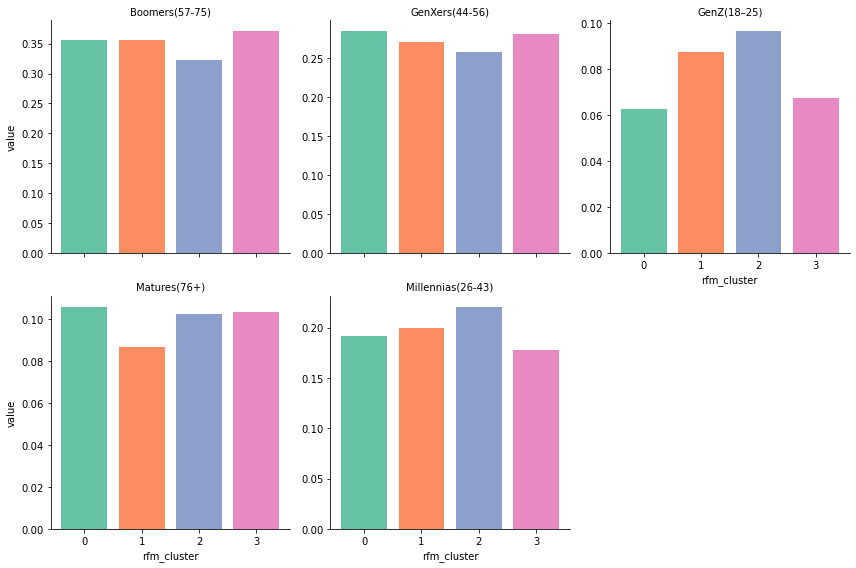

In [20]:
profile_offer_age = profile_offer[['customer_id', 'GenZ(18–25)', 'Millennias(26-43)',
                      'GenXers(44-56)', 'Boomers(57-75)',
                        'Matures(76+)','rfm_cluster']]

plot_data(profile_offer_age)

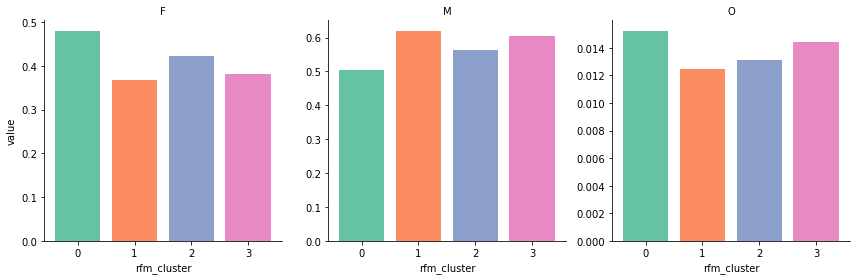

In [37]:
test_4 = profile_offer[['customer_id','F','M','O', 'rfm_cluster']]
plot_data(test_4)

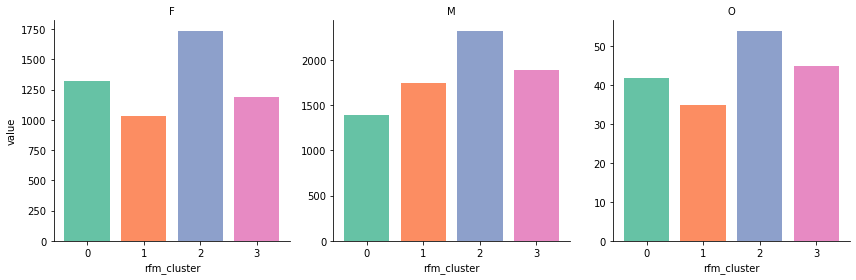

In [38]:
test_22 = profile_offer[['customer_id','F','M','O', 'rfm_cluster']]
plot_data_1(test_22)

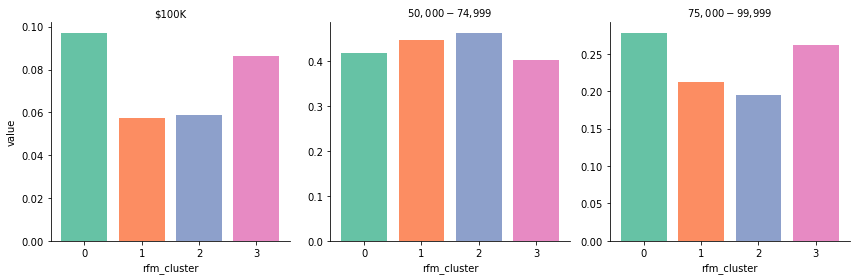

In [24]:
test_5 = profile_offer[['customer_id','$50,000 - $74,999','$75,000 - $99,999','$100K', 'rfm_cluster']]
plot_data(test_5)

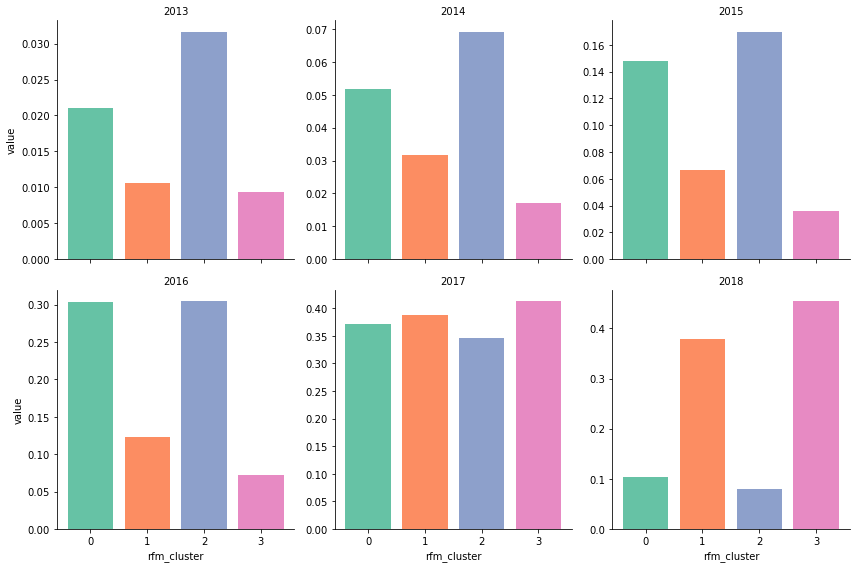

In [25]:
test_6 = profile_offer[['customer_id',2013,2014,2015,2016,2017,2018, 'rfm_cluster']]

plot_data(test_6)

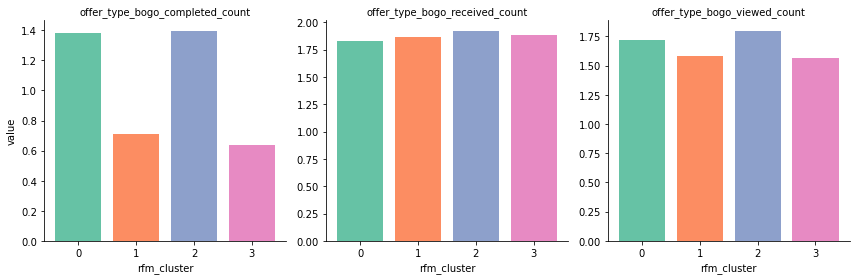

In [26]:
test_7 = profile_offer[['customer_id','offer_type_bogo_received_count','offer_type_bogo_viewed_count',
   'offer_type_bogo_completed_count', 'rfm_cluster']]

plot_data(test_7)

In [ ]:
test_2[['customer_id','offer_type_bogo_received_count','offer_type_bogo_viewed_count',
   'offer_type_bogo_completed_count', 'rfm_cluster']]

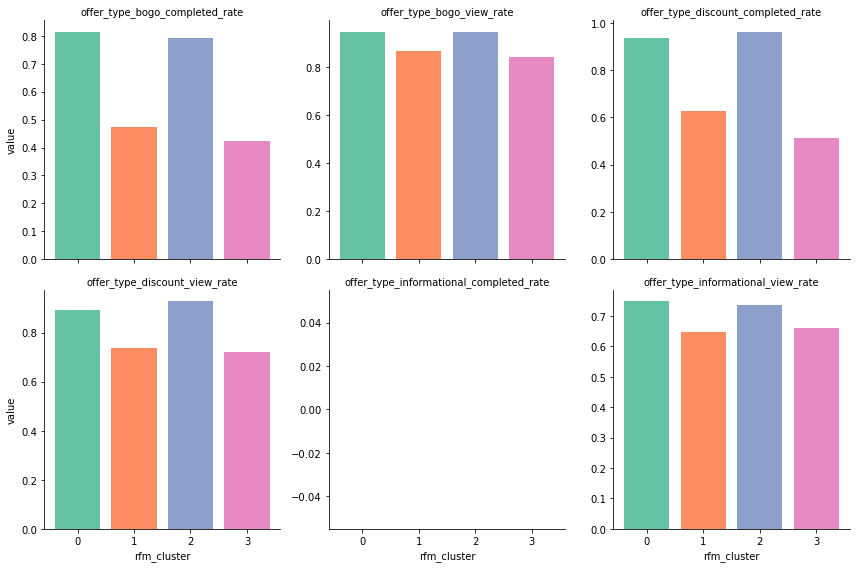

In [27]:
test_8 =  profile_offer[['customer_id','offer_type_bogo_view_rate',
 'offer_type_bogo_completed_rate',

 'offer_type_discount_view_rate',
 'offer_type_discount_completed_rate',

 'offer_type_informational_view_rate',
 'offer_type_informational_completed_rate','rfm_cluster']]

plot_data(test_8)

In [ ]:
test_9 =  test_2[['customer_id',
 'offer_name_offer_1_view_rate',
 'offer_name_offer_1_completed_rate','rfm_cluster']]

plot_data(test_9)



In [ ]:

test_10 =  test_2[['customer_id',
 'offer_name_offer_2_view_rate',
 'offer_name_offer_2_completed_rate','rfm_cluster']]

plot_data(test_10)


In [ ]:
 test_11= test_2[['customer_id', 'rfm_cluster','offer_name_offer_1_view_rate',
 'offer_name_offer_1_completed_rate',
 'offer_name_offer_2_view_rate',
 'offer_name_offer_2_completed_rate',
 'offer_name_offer_3_view_rate',
 'offer_name_offer_3_completed_rate',
 'offer_name_offer_4_view_rate',
 'offer_name_offer_4_completed_rate',
 'offer_name_offer_5_view_rate',
 'offer_name_offer_5_completed_rate',
 'offer_name_offer_6_view_rate',
 'offer_name_offer_6_completed_rate',
 'offer_name_offer_7_view_rate',
 'offer_name_offer_7_completed_rate',
 'offer_name_offer_8_view_rate',
 'offer_name_offer_8_completed_rate',
 'offer_name_offer_9_view_rate',
 'offer_name_offer_9_completed_rate',
 'offer_name_offer_10_view_rate',
 'offer_name_offer_10_completed_rate',
 'offer_difficulty_5_view_rate',
 'offer_difficulty_5_completed_rate',
 'offer_difficulty_20_view_rate',
 'offer_difficulty_20_completed_rate',
 'offer_difficulty_10_view_rate',
 'offer_difficulty_10_completed_rate',
 'offer_difficulty_7_view_rate',
 'offer_difficulty_7_completed_rate',
 'offer_duration_7_view_rate',
 'offer_duration_7_completed_rate',
 'offer_duration_10_view_rate',
 'offer_duration_10_completed_rate',
 'offer_duration_5_view_rate',
 'offer_duration_5_completed_rate',
 'offer_reward_5_view_rate',
 'offer_reward_5_completed_rate',
 'offer_reward_2_view_rate',
 'offer_reward_2_completed_rate',
 'offer_reward_10_view_rate',
 'offer_reward_10_completed_rate',
 'offer_reward_3_view_rate',
 'offer_reward_3_completed_rate']]

In [ ]:
plot_data(test_11)